In [4]:
# tải font cho wordcloud
!wget -O montserrat.ttf "https://github.com/JulietaUla/Montserrat/raw/master/fonts/ttf/Montserrat-Black.ttf"

--2025-05-22 10:20:28--  https://github.com/JulietaUla/Montserrat/raw/master/fonts/ttf/Montserrat-Black.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JulietaUla/Montserrat/master/fonts/ttf/Montserrat-Black.ttf [following]
--2025-05-22 10:20:28--  https://raw.githubusercontent.com/JulietaUla/Montserrat/master/fonts/ttf/Montserrat-Black.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 462844 (452K) [application/octet-stream]
Saving to: ‘montserrat.ttf’

montserrat.ttf      100%[===================>] 452.00K  --.-KB/s    in 0.06s   

2025-05-22 10:20:28 (7.19 MB/s) - ‘montserrat.ttf’ saved

In [34]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

# PySpark SQL
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.types import ArrayType, NumericType, IntegerType, StringType, FloatType, DoubleType
from pyspark.sql.types import StructType, StructField
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col, from_json, explode, lower, trim

# PySpark ML
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer

# PhoBERT & Tensorflow
import torch
from transformers import AutoTokenizer, AutoModel
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping

# Scikit learn for Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

# Natural Language Processing Libraries
from pyvi import ViTokenizer, ViPosTagger
from underthesea import ner
import re
import emoji
import unicodedata

from functools import reduce

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Save and Load model
import pickle


import warnings
warnings.filterwarnings('ignore')

In [6]:
plt.style.use('default')

---
# **1. Lưu data vào HDFS và import vào Spark DF**
---

Cài đặt HDFS

In [ ]:
!apt-get update > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://downloads.apache.org/hadoop/common/hadoop-3.3.5/hadoop-3.3.5.tar.gz

!tar -xzf hadoop-3.3.5.tar.gz
!copy  hadoop file to user/local
!mv  hadoop-3.3.5/ /usr/local/

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/bin/bash: line 1: copy: command not found


Thiết lập môi trường

In [13]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"   # default is changed
os.environ["HADOOP_HOME"] = "/usr/local/hadoop-3.3.5/"

# Add Hadoop BIN to PATH
# current_path taken from last command
current_path = os.getenv('PATH')
new_path = current_path+':/usr/local/hadoop-3.3.5/bin/'
os.environ["PATH"] = new_path

**Load các file json tải từ Apify vào HDFS**

In [14]:
# Tạo thư mục đích trên HDFS
!hdfs dfs -mkdir -p /user/tiktok/comments_json
!hdfs dfs -mkdir -p /user/tiktok/videos_json

# Đưa các file JSON từ local lên HDFS
!hdfs dfs -put ./data/raw/comment_data/*.json /user/tiktok/comments_json/
!hdfs dfs -put ./data/raw/video_data/*.json /user/tiktok/videos_json/

**Dùng Spark đọc file json từ HDFS**

In [15]:
# Tạo SparkSession
spark = SparkSession.builder.appName("TikTokSentimentAnalysis").getOrCreate()

In [16]:
# Đọc comment data
comment_df = spark.read.option("multiLine", True).json("/user/tiktok/comments_json/*.json")
comment_df.printSchema()
comment_df.show(5)

root
 |-- avatarThumbnail: string (nullable = true)
 |-- cid: string (nullable = true)
 |-- createTime: long (nullable = true)
 |-- createTimeISO: string (nullable = true)
 |-- diggCount: long (nullable = true)
 |-- input: string (nullable = true)
 |-- likedByAuthor: boolean (nullable = true)
 |-- pinnedByAuthor: boolean (nullable = true)
 |-- repliesToId: string (nullable = true)
 |-- replyCommentTotal: long (nullable = true)
 |-- submittedVideoUrl: string (nullable = true)
 |-- text: string (nullable = true)
 |-- uid: string (nullable = true)
 |-- uniqueId: string (nullable = true)
 |-- videoWebUrl: string (nullable = true)

+--------------------+-------------------+----------+--------------------+---------+--------------------+-------------+--------------+-----------+-----------------+--------------------+--------------------+-------------------+--------------+--------------------+
|     avatarThumbnail|                cid|createTime|       createTimeISO|diggCount|               inp

In [17]:
print("Số lượng bình luận:", comment_df.count())

Số lượng bình luận: 13007


In [18]:
# Đọc video data
video_df = spark.read.option("multiLine", True).json("/user/tiktok/videos_json/*.json")
video_df.printSchema()
video_df.show(5)

root
 |-- authorMeta: struct (nullable = true)
 |    |-- avatar: string (nullable = true)
 |    |-- bioLink: string (nullable = true)
 |    |-- digg: long (nullable = true)
 |    |-- fans: long (nullable = true)
 |    |-- following: long (nullable = true)
 |    |-- friends: long (nullable = true)
 |    |-- heart: long (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- nickName: string (nullable = true)
 |    |-- originalAvatarUrl: string (nullable = true)
 |    |-- privateAccount: boolean (nullable = true)
 |    |-- profileUrl: string (nullable = true)
 |    |-- signature: string (nullable = true)
 |    |-- ttSeller: boolean (nullable = true)
 |    |-- verified: boolean (nullable = true)
 |    |-- video: long (nullable = true)
 |-- collectCount: long (nullable = true)
 |-- commentCount: long (nullable = true)
 |-- createTime: long (nullable = true)
 |-- createTimeISO: string (nullable = true)
 |-- detailedMentions: array (nullabl

Loại bỏ video bị trùng lặp và giữ lại các video có ngôn ngữ vi hoặc en

In [19]:
video_df = video_df.dropDuplicates(["id"])
video_df = video_df.filter((col("textLanguage") == "vi") | (col("textLanguage") == "en"))
print("Số lượng video:", video_df.count())

Số lượng video: 309


---
# **2. Kiểm tra sơ bộ dữ liệu**
---

In [20]:
print(f"Số lượng videos: {video_df.count()}")
print(f"Số lượng comments: {comment_df.count()}")

Số lượng videos: 309
Số lượng comments: 13007


## **2.1. Hiển thị schema của video_df và comment_df**

In [21]:
video_df.printSchema()

root
 |-- authorMeta: struct (nullable = true)
 |    |-- avatar: string (nullable = true)
 |    |-- bioLink: string (nullable = true)
 |    |-- digg: long (nullable = true)
 |    |-- fans: long (nullable = true)
 |    |-- following: long (nullable = true)
 |    |-- friends: long (nullable = true)
 |    |-- heart: long (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- nickName: string (nullable = true)
 |    |-- originalAvatarUrl: string (nullable = true)
 |    |-- privateAccount: boolean (nullable = true)
 |    |-- profileUrl: string (nullable = true)
 |    |-- signature: string (nullable = true)
 |    |-- ttSeller: boolean (nullable = true)
 |    |-- verified: boolean (nullable = true)
 |    |-- video: long (nullable = true)
 |-- collectCount: long (nullable = true)
 |-- commentCount: long (nullable = true)
 |-- createTime: long (nullable = true)
 |-- createTimeISO: string (nullable = true)
 |-- detailedMentions: array (nullabl

In [22]:
comment_df.printSchema()

root
 |-- avatarThumbnail: string (nullable = true)
 |-- cid: string (nullable = true)
 |-- createTime: long (nullable = true)
 |-- createTimeISO: string (nullable = true)
 |-- diggCount: long (nullable = true)
 |-- input: string (nullable = true)
 |-- likedByAuthor: boolean (nullable = true)
 |-- pinnedByAuthor: boolean (nullable = true)
 |-- repliesToId: string (nullable = true)
 |-- replyCommentTotal: long (nullable = true)
 |-- submittedVideoUrl: string (nullable = true)
 |-- text: string (nullable = true)
 |-- uid: string (nullable = true)
 |-- uniqueId: string (nullable = true)
 |-- videoWebUrl: string (nullable = true)



## **2.2. Thống kê mô tả các cột dữ liệu số**

Thống kê mô tả video_df

In [23]:
# Lọc các cột có kiểu dữ liệu số (IntegerType, LongType, DoubleType, etc.)
numeric_columns = [f.name for f in video_df.schema.fields if isinstance(f.dataType, NumericType)]
video_df.select(numeric_columns).describe().show()

+-------+------------------+-----------------+--------------------+------------------+-----------------+------------------+
|summary|      collectCount|     commentCount|          createTime|         diggCount|        playCount|        shareCount|
+-------+------------------+-----------------+--------------------+------------------+-----------------+------------------+
|  count|               309|              309|                 309|               309|              309|               309|
|   mean|1922.1423948220065|            317.0|1.7134821276601942E9|20356.168284789645|789773.2556634304| 523.8770226537217|
| stddev|6685.1363306127605|823.3976726179925|  3.08474420719096E7| 73576.72227803695|2327024.561340124|1770.4538152971395|
|    min|                 0|                0|          1601475088|                 3|              149|                 0|
|    max|             64300|             7048|          1746114677|            685600|         20100000|             16800|
+-------

Thống kê mô tả comment_df

In [24]:
numeric_columns = [f.name for f in comment_df.schema.fields if isinstance(f.dataType, NumericType)]
comment_df.select(numeric_columns).describe().show()

+-------+--------------------+------------------+------------------+
|summary|          createTime|         diggCount| replyCommentTotal|
+-------+--------------------+------------------+------------------+
|  count|               13007|             13007|             11156|
|   mean| 1.715248872449681E9|19.383870223725687|1.8241305127285765|
| stddev|3.0607197606735624E7| 324.7651302801994| 9.448366105248338|
|    min|          1601475584|                 0|                 0|
|    max|          1746129276|             24748|               551|
+-------+--------------------+------------------+------------------+



---
# **3. EDA Metadata liên quan đến video**
---

## **3.1. Tính tổng số lượt xem, lượt thích, chia sẻ, bình luận, và lưu trữ video**

In [25]:
# Tính tổng số lượt xem, lượt thích, chia sẻ, bình luận, và lưu trữ video
video_summary = video_df.select(
    F.sum(F.col("playCount")).alias("total_playCount"),
    F.sum(F.col("diggCount")).alias("total_diggCount"),
    F.sum(F.col("shareCount")).alias("total_shareCount"),
    F.sum(F.col("commentCount")).alias("total_commentCount"),
    F.sum(F.col("collectCount")).alias("total_collectCount")
)

video_summary.show()

+---------------+---------------+----------------+------------------+------------------+
|total_playCount|total_diggCount|total_shareCount|total_commentCount|total_collectCount|
+---------------+---------------+----------------+------------------+------------------+
|      244039936|        6290056|          161878|             97953|            593942|
+---------------+---------------+----------------+------------------+------------------+



## **3.2. Hiển thị các video với mức độ tương tác cao nhất**

### 3.2.1. Top 10 video có lượt xem cao nhất

In [ ]:
print('Top 10 video có lượt xem cao nhất')
video_df.filter(col("playCount").isNotNull()).orderBy(col("playCount").desc()).select("id", "text", "playCount", "diggCount", "shareCount", "commentCount").show(10, truncate=False)

Top 10 video có lượt xem cao nhất
+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+---------+----------+------------+
|id                 |text                                                                                                                                                                                                                                                                |playCount|diggCount|shareCount|commentCount|
+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+---------+----------

### 3.2.2. Top 10 video có lượt thích cao nhất

In [ ]:
print('Top 10 video có lượt thích cao nhất')
video_df.filter(col("diggCount").isNotNull()).orderBy(col("diggCount").desc()).select("id", "text", "playCount", "diggCount", "shareCount", "commentCount").show(10, truncate=False)

Top 10 video có lượt thích cao nhất
+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+---------+----------+------------+
|id                 |text                                                                                                                                                                                                                                  |playCount|diggCount|shareCount|commentCount|
+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+---------+----------+------------+
|7115613088149343514|Thua luôn! #halinhofficial #kemchongnang #ReviewLamD

## **3.3. Phân tích hành vi tương tác với video quảng bá sản phẩm**

Mục tiêu: Tìm hiểu sự khác biệt về tương tác giữa video quảng cáo (isAd = True) và video thường.

In [ ]:
video_df.groupBy("isAd").agg(
    F.count("*").alias("video_count"),
    F.avg("diggCount").alias("avg_likes"),
    F.avg("shareCount").alias("avg_shares"),
    F.avg("commentCount").alias("avg_comments"),
    F.avg("playCount").alias("avg_views")
).show()

+-----+-----------+------------------+------------------+-----------------+------------------+
| isAd|video_count|         avg_likes|        avg_shares|     avg_comments|         avg_views|
+-----+-----------+------------------+------------------+-----------------+------------------+
| true|         42|37438.142857142855|  862.952380952381|516.1428571428571| 2734702.380952381|
|false|        267|17669.116104868914|470.53932584269666|285.6741573033708|483829.34831460676|
+-----+-----------+------------------+------------------+-----------------+------------------+



- playCount cho biết video tiếp cận đến bao nhiêu người, còn diggCount cho biết bao nhiêu người thực sự thích video đó.
- Tỷ lệ (diggCount + commentCount +shareCount) / playCount có thể dùng để đo mức độ tương tác (engagement rate) hoặc mức độ gây ấn tượng của nội dung.

In [ ]:
# Tính engagement_rate và lấy giá trị trung bình theo isAd
engagement_df = video_df.withColumn("engagement_rate",(col("diggCount") + col("shareCount") + col("commentCount")) / col("playCount"))\
                                    .groupBy("isAd").agg(F.avg("engagement_rate").alias("avg_engagement_rate"))

# Chuyển sang Pandas để vẽ biểu đồ
engagement_pd = engagement_df.toPandas().sort_values("isAd")

labels = ['Non-Ads', 'Ads']
engagement_rates = engagement_pd['avg_engagement_rate'].tolist()

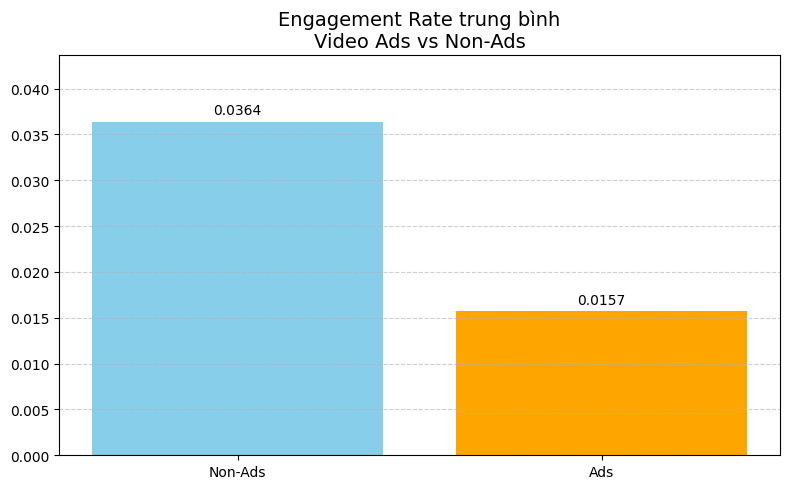

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, engagement_rates, color=['skyblue', 'orange'])

# Ghi giá trị lên từng cột
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.4f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=10)

plt.title('Engagement Rate trung bình\nVideo Ads vs Non-Ads', fontsize=14)
plt.ylim(0, max(engagement_rates) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

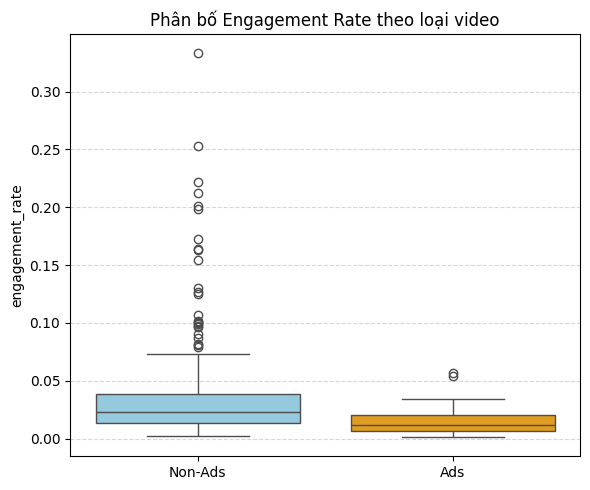

In [ ]:
# Chuyển về pandas để vẽ boxplot phân bố engagement_rate
videos_pd = video_df.withColumn("engagement_rate",(col("diggCount") + col("shareCount") + col("commentCount")) / col("playCount")) \
                     .select("isAd", "engagement_rate") \
                     .dropna().toPandas()

plt.figure(figsize=(6,5))
sns.boxplot(data=videos_pd, x='isAd', y='engagement_rate', palette=['skyblue', 'orange'])
plt.xticks([0,1], ['Non-Ads', 'Ads'])
plt.xlabel(None)
plt.title("Phân bố Engagement Rate theo loại video")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## **3.4. Thống kê hashtags**

In [ ]:
# Tách từng hashtag trong mảng
hashtags_df = video_df.withColumn("hashtag", explode(col("hashtags"))) \
                      .select(col("hashtag.name").alias("hashtag_name"))

# Làm sạch (loại null, rỗng, chuyển thường + trim)
hashtags_df_cleaned = hashtags_df.filter(
    (col("hashtag_name").isNotNull()) & (col("hashtag_name") != "")
).withColumn("hashtag_name", lower(trim(col("hashtag_name"))))

# Đếm số lần xuất hiện các hashtag
hashtags_df_cleaned.groupBy("hashtag_name") \
                   .count() \
                   .orderBy("count", ascending=False) \
                   .show(10, truncate=False)

+------------+-----+
|hashtag_name|count|
+------------+-----+
|kemchongnang|116  |
|reviewlamdep|82   |
|goclamdep   |80   |
|skincare    |62   |
|beplain     |53   |
|beautytok   |47   |
|larocheposay|46   |
|kcn         |45   |
|xuhuong     |43   |
|fyp         |36   |
+------------+-----+
only showing top 10 rows



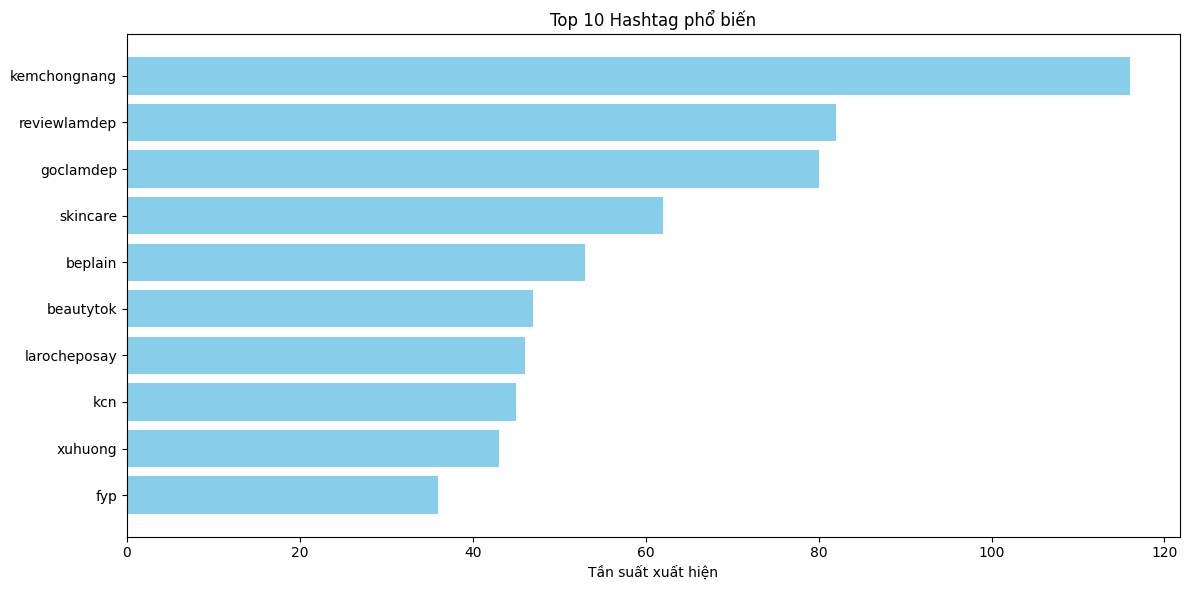

In [ ]:
# Lấy top 10 hashtag và chuyển thành pandas DataFrame
top10_hashtags = hashtags_df_cleaned.groupBy("hashtag_name") \
                   .count() \
                   .orderBy("count", ascending=False) \
                   .limit(10).toPandas()

# Vẽ biểu đồ
plt.figure(figsize=(12,6))
plt.barh(top10_hashtags['hashtag_name'], top10_hashtags['count'], color='skyblue')
plt.xlabel("Tần suất xuất hiện")
# plt.ylabel("Hashtag")
plt.title("Top 10 Hashtag phổ biến")
plt.gca().invert_yaxis()  # Đảo ngược trục Y để hashtag có số lượng cao nhất ở trên cùng
plt.tight_layout()
plt.show()

---
# **4. Tiền xử lý văn bản**
---

## **4.1. Danh sách từ cần tra cứu**

Vì tách từ bằng PyVi sẽ có dấu gạch nối giữa các âm tiết.

Cần chuyển danh sách stopword, teencode thành dạng có dấu gạch chân nối giữa các âm tiết

In [7]:
teencode_dict = {}
with open("/content/drive/MyDrive/Năm 3/Big Data/Nhom01/data/teencode4.txt", "r", encoding="utf-8") as f:
    for line in f:
        if "\t" in line:
            key, value = line.strip().split("\t")
            key = key.replace(" ", "_")
            value = value.replace(" ", "_")
            teencode_dict[key] = value

stopword_list = []
with open("/content/drive/MyDrive/Năm 3/Big Data/Nhom01/data/vietnamese-stopwords.txt", "r", encoding="utf-8") as f:
    for line in f:
        stopword = line.strip().replace(" ", "_")
        if stopword:
            stopword_list.append(stopword)

print("Teencode dictionary:")
print(teencode_dict)

print("\nStopword list:")
print(stopword_list)

Teencode dictionary:
{'ctrai': 'con_trai', 'khôg': 'không', 'bme': 'bố_mẹ', 'cta': 'chúng_ta', 'mih': 'mình', 'cmnl': 'con_mẹ_nó_luôn', 'mqh': 'mối_quan_hệ', 'ùi': 'rồi', 'sem': 'xem', 'pải': 'phải', 'đel': 'đéo', 'cgai': 'con_gái', 'nhữg': 'những', 'mng': 'mọi_người', 'r': 'rồi', 'qtam': 'quan_tâm', 'thươg': 'thương', 'lun': 'luôn', 'cute': 'dễ_thương', 'kute': 'dễ_thương', 'ưi': 'ơi', 'kao': 'tao', 'tau': 'tao', 'gê': 'ghê', 'ge': 'ghê', 'kau': 'tao', 'rùi': 'rồi', 'qtâm': 'quan_tâm', 'share': 'chia_sẻ', 'chug': 'chung', 'vại': 'vậy', 'trườg': 'trường', 'hjx': 'hic', 'hix': 'hic', 'thoy': 'thôi', 'oy': 'rồi', 'đki': 'đăng_ký', 'àk': 'à', 'qcao': 'quảng_cáo', 'pr': 'quảng_cáo', 'cv': 'công_việc', 'tr': 'trời', 'vch': 'vãi_chưởng', 'cùg': 'cùng', 'thjck': 'thích', 'thjk': 'thích', 'ktra': 'kiểm_tra', 'cgái': 'con_gái', 'nthe': 'như_thế', 'chúg': 'chúng', 'tìh': 'tình', 'phòg': 'phòng', 'lòg': 'lòng', 'từg': 'từng', 'rằg': 'rằng', 'sốg': 'sống', 'thuj': 'thôi', 'càg': 'càng', 'đky': 'đă

In [8]:
merge_phrases = ['kem chống nắng', 'kiềm dầu', 'da dầu', 'da khô',
                 'chỉ số chống nắng', 'giá cả', 'chính hãng',
                 'lừa đảo', 'kháng nước', 'chống nước', 'vệt trắng',
                 'nâng tông', 'nâng tone', 'bí da', 'dung tích']

## **4.2. Hàm tiền xử lý văn bản**

In [9]:
def replace_merge_phrases(text, merge_phrases):
    for phrase in merge_phrases:
        underscored = phrase.replace(' ', '_')
        text = re.sub(rf"\b{re.escape(phrase)}\b", underscored, text, flags=re.IGNORECASE)
    return text

# ===== Phase 1: Normalize =====
def normalize_text(text):
    # Lowercase Sentences
    text = text.lower()
    # Loại bỏ tất cả ký tự đặc biệt, trừ chữ cái, số, dấu cách, dấu ? và !
    text = re.sub(r"[^a-zA-Z0-9À-Ỵà-ỵ\s!?]", " ", text)
    # Delete Redundant Spaces
    text = re.sub(r"\s+", " ", text).strip()
    # Delete Links
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Delete @mentions
    text = re.sub(r'@\w+', '', text)
    # Normalize Unicode
    text = unicodedata.normalize("NFC", text)
    # De-emoji
    text = emoji.demojize(text, delimiters=(" ", " "))

    return text

def process_text(text, remove_stopwords=True, return_str=False):
    # --- Phase 1 ---
    norm = normalize_text(text)

    # Thay thế cụm từ ghép
    norm = replace_merge_phrases(norm, merge_phrases)

    # --- Phase 2 ---
    # Tokenize
    tokens = ViTokenizer.tokenize(norm).split()
    # De-teencode
    tokens = [teencode_dict.get(tok, tok) for tok in tokens]
    # Remove stopwords
    if remove_stopwords == True:
        tokens = [tok for tok in tokens if tok not in stopword_list]
    if return_str:
        return " ".join(tokens)
    return tokens

Đăng ký UDF cho 3 chế độ:
- trả về list token
- trả về chuỗi token được nối lại
- trả về chuỗi token được nối lại, giữ stopwords

In [10]:
tokenized_text_udf = udf(process_text, ArrayType(StringType()))
cleaned_text_udf = udf(lambda text: process_text(text, return_str=True), StringType())
cleaned_text_stopwords_udf = udf(lambda text: process_text(text, remove_stopwords=False, return_str=True), StringType())

# **5. EDA dữ liệu bình luận**

## **5.1. Lọc ra comment ở các video tiếng Việt**

In [26]:
# Tìm các cột trùng tên giữa hai DataFrame
common_columns = list(set(video_df.columns) & set(comment_df.columns))

print("Các cột trùng tên giữa video_df và comment_df:")
for col in common_columns:
    print(col)

Các cột trùng tên giữa video_df và comment_df:
diggCount
text
createTimeISO
createTime


In [27]:
# Đổi tên các cột trùng nhau
for col in common_columns:
    video_df = video_df.withColumnRenamed(col, col + "_video")
    comment_df = comment_df.withColumnRenamed(col, col + "_comment")

In [28]:
# Join hai DataFrame theo cột videoWebUrl
joined_df = video_df.join(
    comment_df,
    video_df.webVideoUrl == comment_df.videoWebUrl,
    "inner"
)

joined_df.show()

+--------------------+------------+------------+----------------+--------------------+----------------+---------------+--------------+--------+-------------------+-----+-------+--------+-----------+------------+--------------------+--------+--------------------+---------+--------------------+----------+--------------------+------------+--------------------+--------------------+--------------------+-------------------+------------------+---------------------+-----------------+--------------------+-------------+--------------+-----------+-----------------+--------------------+--------------------+-------------------+--------------+--------------------+
|          authorMeta|collectCount|commentCount|createTime_video| createTimeISO_video|detailedMentions|diggCount_video|effectStickers|hashtags|                 id| isAd|isMuted|isPinned|isSlideshow|locationMeta|           mediaUrls|mentions|           musicMeta|playCount|         searchQuery|shareCount|          text_video|textLanguage|   

In [29]:
# Lọc ra các comment trong video bằng tiếng Việt (textLanguage = "vi")
vietnamese_joined_df = joined_df.filter(joined_df.textLanguage == "vi")
vietnamese_joined_df.show()

+--------------------+------------+------------+----------------+--------------------+----------------+---------------+--------------+--------+-------------------+-----+-------+--------+-----------+------------+--------------------+--------+--------------------+---------+--------------------+----------+--------------------+------------+--------------------+--------------------+--------------------+-------------------+------------------+---------------------+-----------------+--------------------+-------------+--------------+-----------+-----------------+--------------------+--------------------+-------------------+--------------+--------------------+
|          authorMeta|collectCount|commentCount|createTime_video| createTimeISO_video|detailedMentions|diggCount_video|effectStickers|hashtags|                 id| isAd|isMuted|isPinned|isSlideshow|locationMeta|           mediaUrls|mentions|           musicMeta|playCount|         searchQuery|shareCount|          text_video|textLanguage|   

Load file đã gắn nhãn

In [30]:
labeled_comment_df = spark.read.option("header", True) \
    .option("multiLine", True) \
    .option("quote", '"') \
    .option("escape", '"') \
    .option("mode", "PERMISSIVE") \
    .option("delimiter", "\t") \
    .csv("./data/processed/all_comments_labeled.tsv", inferSchema=True)

labeled_comment_df = labeled_comment_df.select("cid", "label")
labeled_comment_df.show()

+-------------------+-----+
|                cid|label|
+-------------------+-----+
|6978487559790527233|  pos|
|6977749499381121793|  neu|
|6980963679337005851|  neg|
|6977385265648173826|  neu|
|6977383620424762138|  neu|
|6980928297367257882|  neu|
|6977600660372554497|  neu|
|6990764291179905818|  neg|
|6981463448757191450|  neg|
|6980661572121854747|  neu|
|6979129336007852802|  neu|
|6977945322748478209|  neu|
|7042487303478330114|  neu|
|7040232429055410945|  neu|
|7015880551966327578|  neg|
|7012420241431184154|  neu|
|7010237850784662273|  neu|
|7009300196111336193|  neu|
|7008426021674664730|  neg|
|6998492825595675418|  neu|
+-------------------+-----+
only showing top 20 rows



Join labeled_comment_df với vietnamese_joined_df

In [31]:
df = vietnamese_joined_df.join(
    labeled_comment_df,
    vietnamese_joined_df.cid == labeled_comment_df.cid,
    "inner"
).select(vietnamese_joined_df.cid, vietnamese_joined_df.text_comment, labeled_comment_df.label)

df.show(truncate=100)

+-------------------+----------------------------------------------------------------------------------------------------+-----+
|                cid|                                                                                        text_comment|label|
+-------------------+----------------------------------------------------------------------------------------------------+-----+
|7088539169525613313|                        mình thấy skin aqua tone up màu xanh lá cũng ổn , dành cho da dầu ít mụn nha| NULL|
|7088544330666771201|                      Đang dùng Skin aqua nắp vàng 2 năm rồi . Rất ưng và kh có ý định đổi loại khác| NULL|
|7088557921709392641|                                                          Số 7: lên da cảm thấy mướt, thấm nhanh, rẻ| NULL|
|7088543928579851009|10. ổn, thấm nhanh, dễ tán, nâng tone nhẹ ko bị giả nhưng mà bôi sẽ bị bết nha. bạn nào da dầu ha...| NULL|
|7088544043407393537|1- bạn nào da nhạy cảm hay dầu mụn thì né em này . Mình khuyên thật kiềm dầu

In [32]:
print(f"Có tổng cộng {df.count()} bình luận được lấy từ các video tiếng Việt")

Có tổng cộng 11298 bình luận được lấy từ các video tiếng Việt


In [35]:
# Áp dụng xử lý lên cột text_comment
df_tokenized = df.withColumn("tokens", tokenized_text_udf(col("text_comment")))
df_cleaned = df.withColumn("cleaned_text", cleaned_text_udf(col("text_comment")))
df_cleaned_stopwords = df.withColumn("cleaned_text_stopwords", cleaned_text_stopwords_udf(col("text_comment")))

print("Tokenized Dataframe:")
print(df_tokenized.select("text_comment", "tokens").show(truncate=100))
print()
print("Cleaned Dataframe:")
print(df_cleaned.select("text_comment", "cleaned_text").show(truncate=100))
print()
print("Cleaned Dataframe, keep stopwords:")
print(df_cleaned_stopwords.select("text_comment", "cleaned_text_stopwords").show(truncate=100))

Tokenized Dataframe:
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                        text_comment|                                                                                              tokens|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                        mình thấy skin aqua tone up màu xanh lá cũng ổn , dành cho da dầu ít mụn nha|                                         [skin, aqua, tone, up, màu, xanh, lá, ổn, da_dầu, mụn, nha]|
|                      Đang dùng Skin aqua nắp vàng 2 năm rồi . Rất ưng và kh có ý định đổi loại khác|                                                        [skin

## **5.2. Dùng Count Vectorizer thống kê tần suất xuất hiện của từ**

In [36]:
cv = CountVectorizer(inputCol="tokens", outputCol="features", vocabSize=5000, minDF=2.0)
cv_model = cv.fit(df_tokenized)
result = cv_model.transform(df_tokenized)

vocabulary = cv_model.vocabulary  # từ gốc

In [37]:
# Chuyển vector thành danh sách số
def vector_to_array(v):
    return v.toArray().tolist()

vector_to_array_udf = udf(vector_to_array, ArrayType(DoubleType()))
word_freq_df = result.withColumn("freq_array", vector_to_array_udf(col("features")))

In [38]:
# RDD chứa vector tần suất
freq_rdd = result.select("features").rdd.map(lambda row: row["features"].toArray())

# Cộng tất cả vector (element-wise sum)
total_freq = freq_rdd.reduce(lambda x, y: x + y)

# Ghép từ vựng với tần suất
word_freq = list(zip(vocabulary, total_freq))

# Sắp xếp giảm dần theo tần suất
word_freq_sorted = sorted(word_freq, key=lambda x: -x[1])

### 5.2.1. Thống kê các từ xuất hiện nhiều nhất

In [39]:
for word, freq in word_freq_sorted[:30]:
    print(f"{word}: {int(freq)}")

kcn: 1404
da: 1404
mua: 987
pass: 959
đi: 866
mụn: 825
tím: 703
xanh: 658
xài: 654
nha: 651
tui: 623
da_dầu: 596
lắm: 567
bôi: 537
?: 515
tao: 494
màu: 485
beplain: 428
1: 415
kem: 402
nắng: 372
ok: 369
mặt: 358
sài: 358
dầu: 354
chống: 348
lá: 347
nâng_tone: 324
anessa: 318
đẹp: 308


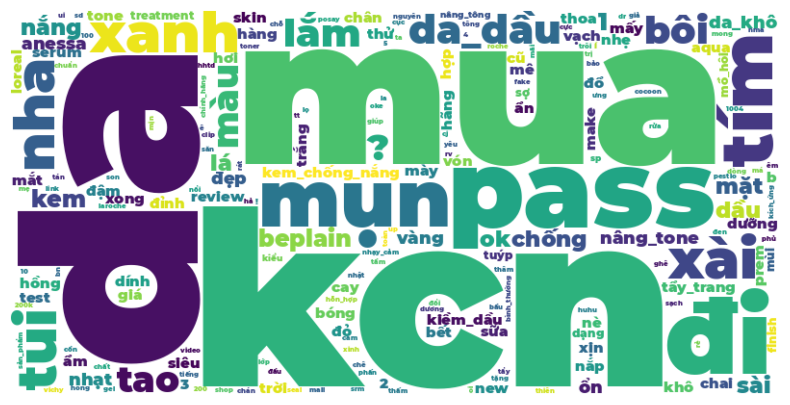

In [40]:
# Tạo một dictionary từ danh sách (word, frequency)
word_freq_dict = dict(word_freq_sorted)

# Tạo word cloud
wordcloud = WordCloud(font_path='montserrat.ttf', width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 5.2.2. Thống kê các từ có 2 âm tiết trở lên xuất hiện nhiều nhất

In [41]:
for word, freq in word_freq_sorted:
    if "_" in word:
        print(f"{word}: {int(freq)}")

da_dầu: 596
nâng_tone: 324
da_khô: 294
kem_chống_nắng: 278
kiềm_dầu: 275
tẩy_trang: 216
mồ_hôi: 111
nâng_tông: 108
nhạy_cảm: 92
chính_hãng: 86
hỗn_hợp: 83
sản_phẩm: 61
kích_ứng: 50
bình_thường: 48
tự_nhiên: 42
việt_nam: 40
tham_khảo: 40
vật_lý: 39
trộm_vía: 38
chống_nước: 37
cảm_giác: 33
khó_chịu: 32
khẩu_trang: 32
kháng_nước: 31
bí_da: 29
tuyệt_vời: 29
người_ta: 28
bác_sĩ: 27
đại_hội: 26
vệt_trắng: 26
kinh_khủng: 26
lên_mặt: 24
dễ_thương: 24
cực_kì: 24
khả_năng: 24
thiên_dầu: 24
châm_chích: 23
bình_luận: 23
ổn_áp: 22
hoá_học: 21
quảng_cáo: 21
hiệu_quả: 20
vàng_khè: 20
phục_hồi: 20
chất_lượng: 19
hoang_mang: 19
mặc_dù: 19
yên_tâm: 19
chị_em: 18
cám_ơn: 18
cảm_nhận: 18
trung_quốc: 17
thành_phần: 17
li_ti: 17
phân_vân: 17
lông_mày: 16
dầu_tẩy_trang: 16
phiên_bản: 16
nhẹ_nhàng: 16
dã_man: 16
khuyết_điểm: 16
ví_dụ: 15
diễu_binh: 15
hình_như: 15
cải_thiện: 14
tư_vấn: 14
kết_hợp: 14
quân_sự: 14
công_nhận: 14
ý_kiến: 14
mặt_nạ: 13
nhược_điểm: 13
tàn_nhang: 13
hà_nội: 13
đất_sét: 12
đậu_xanh: 

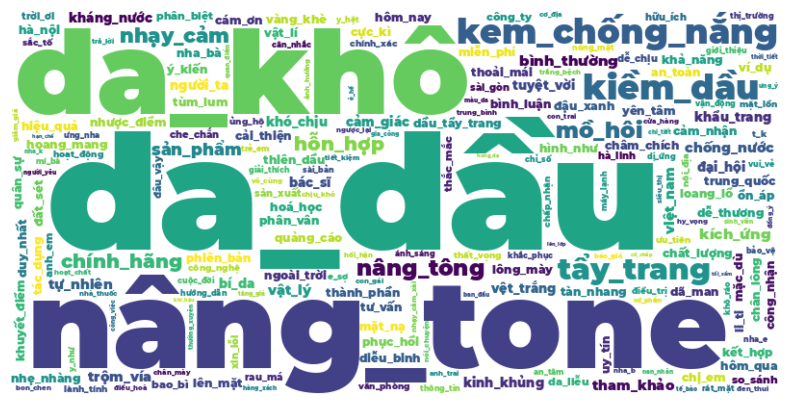

In [42]:
word_freq_dict_2_syllable = {word: freq for word, freq in word_freq_sorted if "_" in word}

wordcloud_2_syllable = WordCloud(font_path='montserrat.ttf', width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict_2_syllable)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_2_syllable, interpolation='bilinear')
plt.axis("off")
plt.show()

## **5.3. POS Tagging**

In [44]:
def plot_wordcloud(counter, title):
    wordcloud = WordCloud(font_path='montserrat.ttf', background_color='white', width=800, height=400).generate_from_frequencies(counter)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

In [46]:
texts = [row["cleaned_text"] for row in df_cleaned.select("cleaned_text").collect()]

# Khởi tạo bộ đếm
noun_counter = Counter()
verb_counter = Counter()
adj_counter = Counter()

for text in texts:
    words, tags = ViPosTagger.postagging(text)

    for word, tag in zip(words, tags):
        if tag == 'N':
            noun_counter[word] += 1
        elif tag == 'V':
            verb_counter[word] += 1
        elif tag == 'A':
            adj_counter[word] += 1

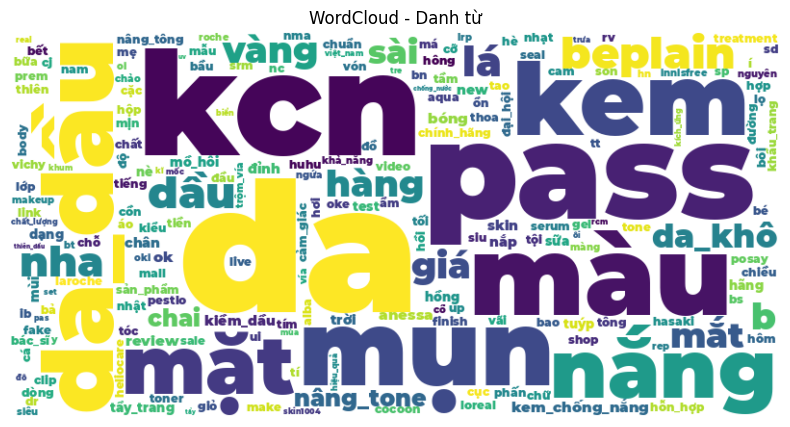

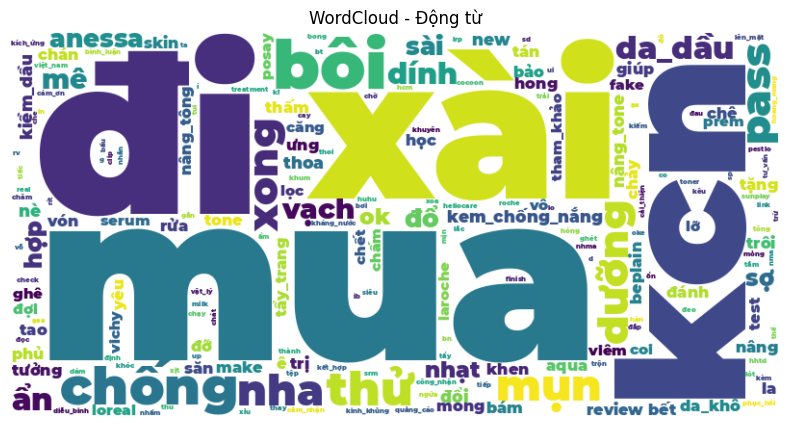

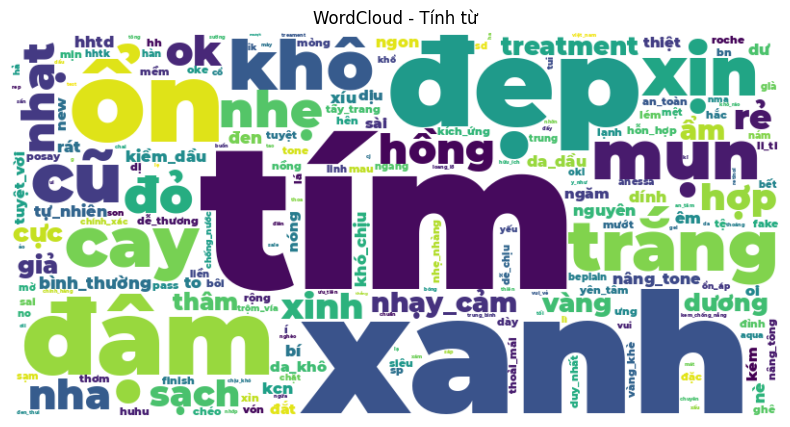

In [48]:
# Vẽ kết quả
plot_wordcloud(noun_counter, "WordCloud - Danh từ")
plot_wordcloud(verb_counter, "WordCloud - Động từ")
plot_wordcloud(adj_counter, "WordCloud - Tính từ")

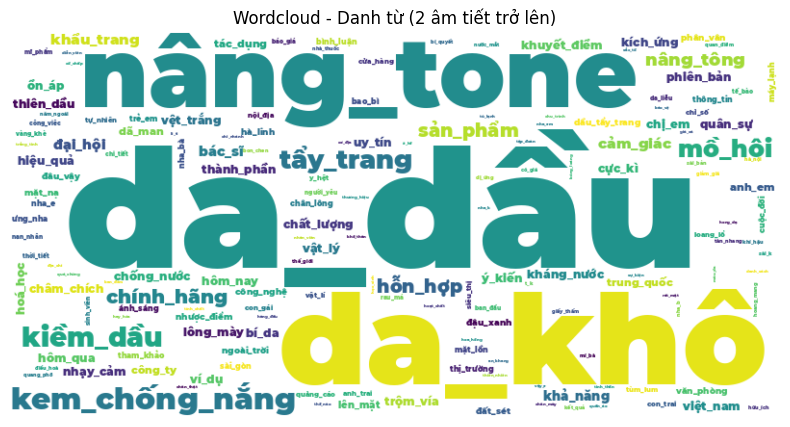

In [47]:
# Vẽ các danh từ có 2 âm tiết trở lên
counter_2_syllable = {word: freq for word, freq in noun_counter.items() if "_" in word}
plot_wordcloud(counter_2_syllable, "Wordcloud - Danh từ (2 âm tiết trở lên)")

## **5.4. Phân phối bình luận theo từng nhãn**

Lọc df_labeled lấy những comment được gắn nhãn

In [ ]:
df_labeled = df.filter(df.label.isNotNull())
print(df_labeled.show(truncate=100))
print("Number of labeled comments:", df_labeled.count())

+-------------------+----------------------------------------------------------------------------------------------------+-----+
|                cid|                                                                                        text_comment|label|
+-------------------+----------------------------------------------------------------------------------------------------+-----+
|7498342370448245512|                                         Bôi lên mà tưởng như bôi lotion dưỡng ẩm luôn á, mịn cực kỳ|  pos|
|7498343207978304263|                                              Dùng mấy tiếng mà da không xuống tông xíu nào, yêu ghê|  pos|
|7498342954097820437|                                               Dùng 1 lần là dính, giờ cứ hết là phải đi mua tiếp nè|  pos|
|7464966129452073735|                           T thấy kcn này dùng đúng chán mà trên tik toàn seeding k hiểu tốt chỗ nào|  neg|
|7475694389043790610|         Anessa đào lửa khách, ko hoàn tiền và lấy hàng. Loại mới ra bết chấ

In [ ]:
def plot_label_distribution(df, title="Số lượng bình luận theo nhãn", label_col="label"):
    # Count the number of comments for each label
    label_counts = df.groupBy("label").agg(F.count("*").alias("count"))

    # Convert to Pandas DataFrame for plotting
    label_counts_pd = label_counts.toPandas()

    # Plotting the bar chart
    plt.figure(figsize=(8, 6))
    bars = plt.bar(label_counts_pd["label"], label_counts_pd["count"], color='skyblue')

    # Thêm số lên trên mỗi cột
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 5, str(height),
                ha='center', va='bottom', fontsize=10)

    plt.xlabel("Labels")
    plt.ylabel("Số lượng bình luận")
    plt.title(title)
    plt.tight_layout()
    plt.show()

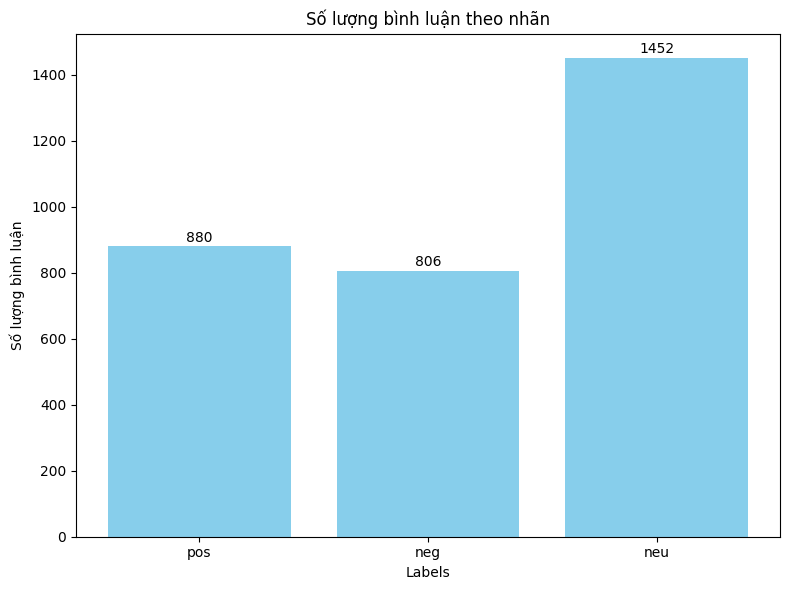

In [ ]:
plot_label_distribution(df_labeled, label_col="label")

## **5.5. Phân phối bình luận theo số lượng từ**

In [ ]:
df_tokenized = df_labeled.withColumn("tokens", tokenized_text_udf(col("text_comment")))
token_counts = df_tokenized.select(F.size("tokens").alias("token_count"))
token_counts_list = [row.token_count for row in token_counts.collect()]

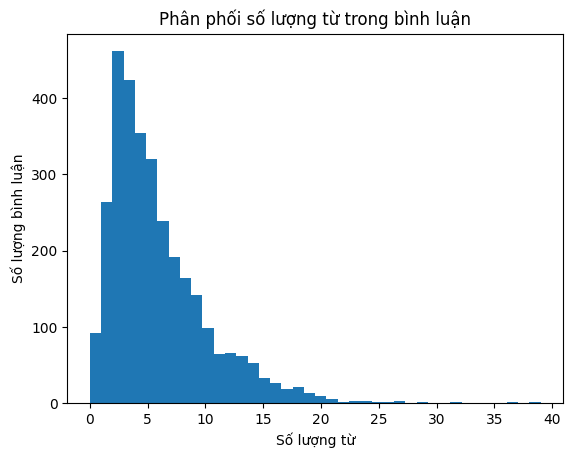

In [ ]:
plt.hist(token_counts_list, bins=40)
plt.xlabel("Số lượng từ")
plt.ylabel("Số lượng bình luận")
plt.title("Phân phối số lượng từ trong bình luận")
plt.show()

---
# **6. Xây dựng mô hình phân tích quan điểm**
---

## **6.1. Mã hóa cột label**
- neg (Negative) => 0
- neu (Neutral) => 1
- pos (Positive) => 2

In [ ]:
df_labeled = df_labeled.withColumn(
    "label_encoded",
    F.when(col("label") == "neg", 0)
    .when(col("label") == "neu", 1)
    .when(col("label") == "pos", 2)
)

df_labeled.show(truncate=50)

+-------------------+--------------------------------------------------+-----+-------------+
|                cid|                                      text_comment|label|label_encoded|
+-------------------+--------------------------------------------------+-----+-------------+
|6978487559790527233|   Cảm ơn bác sĩ chị đang dùnh la roch thấy ok lắm|  pos|            2|
|6977749499381121793|Có loại kcn vật lý hoặc vật lý lai hoá học kiềm...|  neu|            1|
|6980963679337005851|dùng laros toàn để lại ghét k à. bôi xong k tán...|  neg|            0|
|6977385265648173826|          Da dầu thì sài sữa rửa mặt nào v chị ???|  neu|            1|
|6977383620424762138|      còn kem chống nắng cho da thường thì sao ạ??|  neu|            1|
|6980928297367257882|chị ơi e da dầu mụn ẩn sd kcn cell fusionC clea...|  neu|            1|
|6977600660372554497|               cô ơi test sữa rửa mặt simple đi cô|  neu|            1|
|6990764291179905818|E lan dau xài kcn xài eucerin mà mồ hôi mồ kê n..

## **6.2. Chia dữ liệu huấn luyện, đánh giá, kiểm tra**

Sử dụng phương pháp stratified split để đảm bảo rằng mỗi tập con có tỉ lệ nhãn tương ứng như toàn bộ tập dữ liệu.

In [ ]:
# Hàm chia stratified
def stratified_split(df, label_col='label', train_frac=0.65, val_frac=0.15, test_frac=0.2, seed=42):
    labels = [row[label_col] for row in df.select(label_col).distinct().collect()]

    train_dfs = []
    val_dfs = []
    test_dfs = []

    for lbl in labels:
        df_lbl = df.filter(F.col(label_col) == lbl)
        train, val_test = df_lbl.randomSplit([train_frac, 1 - train_frac], seed=seed)
        val, test = val_test.randomSplit([val_frac / (val_frac + test_frac), test_frac / (val_frac + test_frac)], seed=seed)

        train_dfs.append(train)
        val_dfs.append(val)
        test_dfs.append(test)

    train_df = reduce(DataFrame.unionAll, train_dfs)
    val_df = reduce(DataFrame.unionAll, val_dfs)
    test_df = reduce(DataFrame.unionAll, test_dfs)

    return train_df, val_df, test_df

In [ ]:
train_df, val_df, test_df = stratified_split(df_labeled, label_col='label', train_frac=0.65, val_frac=0.15, test_frac=0.2)

print("Train count:", train_df.count())
print("Validation count:", val_df.count())
print("Test count:", test_df.count())

Train count: 2166
Validation count: 425
Test count: 547


Lưu lại thành các file train.tsv, val.tsv, test.tsv

In [ ]:
train_pd = train_df.toPandas()
val_pd = val_df.toPandas()
test_pd = test_df.toPandas()

In [ ]:
train_pd.to_csv('/content/drive/MyDrive/Năm 3/Big Data/Big Data - Đồ án/data/processed/train.tsv', sep='\t', encoding='utf-8', index=False)
val_pd.to_csv('/content/drive/MyDrive/Năm 3/Big Data/Big Data - Đồ án/data/processed/val.tsv', sep='\t', encoding='utf-8', index=False)
test_pd.to_csv('/content/drive/MyDrive/Năm 3/Big Data/Big Data - Đồ án/data/processed/test.tsv', sep='\t', encoding='utf-8', index=False)

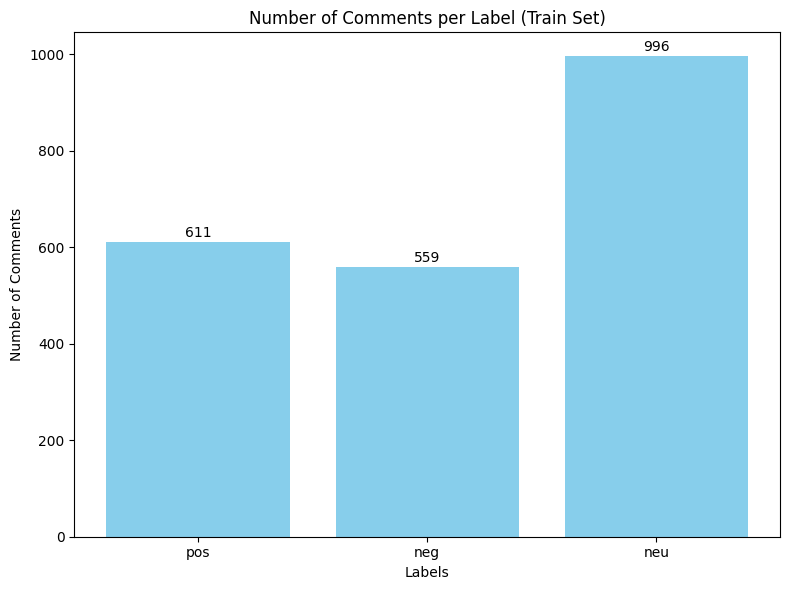

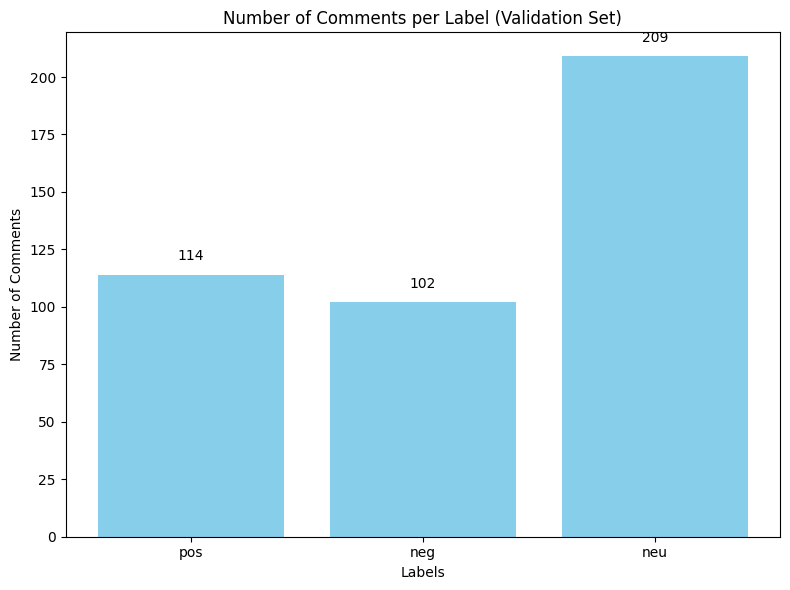

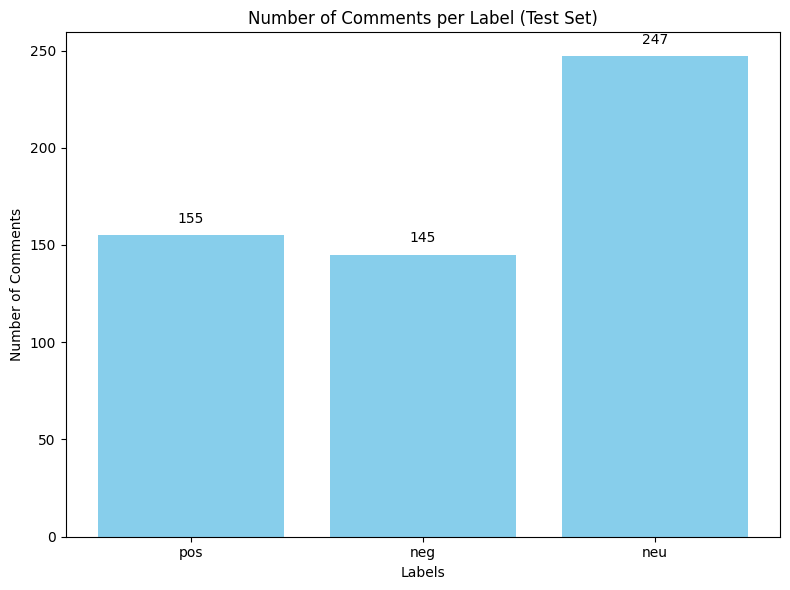

In [ ]:
plot_label_distribution(train_df, label_col="label", title="Number of Comments per Label (Train Set)")
plot_label_distribution(val_df, label_col="label", title="Number of Comments per Label (Validation Set)")
plot_label_distribution(test_df, label_col="label", title="Number of Comments per Label (Test Set)")

## **6.3. PhoBERT + Classifiers**

### 6.3.1. Trích xuất đặc trưng từ văn bản dùng PhoBERT base v2

In [ ]:
phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [ ]:
# Tải dữ liệu train, val, test đã được chia ở phân trước
train_pd = pd.read_csv('/content/drive/MyDrive/Năm 3/Big Data/Big Data - Đồ án/data/processed/train.tsv', sep='\t')
val_pd = pd.read_csv('/content/drive/MyDrive/Năm 3/Big Data/Big Data - Đồ án/data/processed/val.tsv', sep='\t')
test_pd = pd.read_csv('/content/drive/MyDrive/Năm 3/Big Data/Big Data - Đồ án/data/processed/test.tsv', sep='\t')
train_pd.head(4)

,cid,text_comment,label,label_encoded
0,6882343591239565313,Nhược điểm duy nhất: xuống tông sạm đen vào cu...,pos,2
1,6883704234718855170,e này dùng thích lắm nhé😂mình đang dùng thấy n...,pos,2
2,6955423544113725441,mình củng đang xài dạng tuýp này.nó ko bị bết ...,pos,2
3,6978487559790527233,Cảm ơn bác sĩ chị đang dùnh la roch thấy ok lắm,pos,2


Tiền xử lý văn bản bình luận, chọn return_str=True để trả về chuỗi token được nối lại với nhau bằng khoảng trắng

In [ ]:
train_pd['cleaned_text'] = train_pd['text_comment'].apply(lambda x: process_text(x, return_str=True))
val_pd['cleaned_text'] = val_pd['text_comment'].apply(lambda x: process_text(x, return_str=True))
test_pd['cleaned_text'] = test_pd['text_comment'].apply(lambda x: process_text(x, return_str=True))
train_pd.head(4)

,cid,text_comment,label,label_encoded,cleaned_text
0,6882343591239565313,Nhược điểm duy nhất: xuống tông sạm đen vào cu...,pos,2,nhược_điểm duy_nhất tông sạm đen khả_năng bảo_...
1,6883704234718855170,e này dùng thích lắm nhé😂mình đang dùng thấy n...,pos,2,lắm thấm lắm thoa nâng_tone nx mặt mụn bt nc ư...
2,6955423544113725441,mình củng đang xài dạng tuýp này.nó ko bị bết ...,pos,2,củng xài dạng tuýp bết dính tông nhẹ
3,6978487559790527233,Cảm ơn bác sĩ chị đang dùnh la roch thấy ok lắm,pos,2,bác_sĩ dùnh la roch ok lắm


Hàm extract_features trả về một vector NumPy 1 chiều đại diện cho embedding của cả câu, được tính bằng cách trung bình tất cả các vector ẩn (hidden states) của các token.

In [ ]:
def extract_features(text):
    input_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)])
    with torch.no_grad():
        outputs = phobert(input_ids)
        last_hidden_state = outputs[0]
        sentence_embedding = last_hidden_state.mean(dim=1).squeeze().numpy()
    return sentence_embedding

Trích feature cho 3 tập train, val, test

In [ ]:
tqdm.pandas()  # Để theo dõi tiến trình

print("Traning Set")
train_pd["features"] = train_pd["text_comment"].progress_apply(extract_features)
print("\nValidation Set")
val_pd["features"] = val_pd["text_comment"].progress_apply(extract_features)
print("\nTest Set")
test_pd["features"] = test_pd["text_comment"].progress_apply(extract_features)

Traning Set


100%|██████████| 2166/2166 [05:10<00:00,  6.97it/s]



Validation Set


100%|██████████| 425/425 [01:05<00:00,  6.50it/s]



Test Set


100%|██████████| 547/547 [01:16<00:00,  7.18it/s]


In [ ]:
X_train = np.vstack(train_pd["features"].values)
y_train = train_pd["label_encoded"].values

X_val = np.vstack(val_pd["features"].values)
y_val = val_pd["label_encoded"].values

X_test = np.vstack(test_pd["features"].values)
y_test = test_pd["label_encoded"].values

### **6.3.2 PhoBERT + ML models & Hyperparameter tuning**

In [ ]:
# Hàm tối ưu hóa siêu tham số:  k-fold cross validation cùng với random search
def optimize_model(model_name, X, y, param_dist):
    model_class = {
        'LogisticRegression': LogisticRegression,
        'SVC': SVC,
        'RandomForestClassifier': RandomForestClassifier
    }[model_name]

    model = model_class()
    random_search = RandomizedSearchCV(
        model, param_distributions=param_dist, n_iter=25, cv=5,
        n_jobs=-1, scoring='accuracy', random_state=42
    )
    random_search.fit(X, y)

    best_params = random_search.best_params_
    best_score = random_search.best_score_

    return best_params, best_score

In [ ]:
# List các hyperparameter cần tối ưu
param_dists = {
    'LogisticRegression': {
        'C': np.logspace(-4, 4, 20),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'SVC': {
        'C': np.logspace(-2, 10, 20),
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto'] + list(np.logspace(-9, 3, 20)),
    },
    'RandomForestClassifier': {
        'n_estimators': range(50, 500, 50),
        'max_depth': [None] + list(range(10, 110, 10)),
        'min_samples_split': range(2, 20),
        'min_samples_leaf': range(1, 20),
    }
}

Tối ưu hóa tham số, lưu best_params và train lại trên toàn bộ train_val với best_params

In [ ]:
best_models = {}

for model_name, param_dist in param_dists.items():
    print(f"Optimizing {model_name}...")
    best_params, best_score = optimize_model(model_name, X_train, y_train, param_dist)
    print(f"Best hyper-parameters for {model_name}: {best_params}")
    print(f"Best accuracy: {best_score:.4f}")

    # Train lại với best_params
    model_class = {
        'LogisticRegression': LogisticRegression,
        'SVC': SVC,
        'RandomForestClassifier': RandomForestClassifier
    }[model_name]

    model = model_class(**best_params)
    model.fit(X_train, y_train)

    # Đánh giá trên tập test
    y_pred = model.predict(X_test)
    print(f"Test performance ({model_name}):")
    print(classification_report(y_test, y_pred))

    # Lưu model bằng pickle
    with open(f"/content/drive/MyDrive/Năm 3/Big Data/Big Data - Đồ án/model/{model_name}_best_model.pkl", "wb") as f:
        pickle.dump(model, f)

    best_models[model_name] = model
    print("-" * 60)

Optimizing LogisticRegression...
Best hyper-parameters for LogisticRegression: {'solver': 'saga', 'penalty': 'l2', 'C': np.float64(0.23357214690901212)}
Best accuracy: 0.7678
Test performance (LogisticRegression):
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       145
           1       0.85      0.86      0.86       247
           2       0.84      0.82      0.83       155

    accuracy                           0.84       547
   macro avg       0.84      0.84      0.84       547
weighted avg       0.84      0.84      0.84       547

------------------------------------------------------------
Optimizing SVC...
Best hyper-parameters for SVC: {'kernel': 'linear', 'gamma': np.float64(1.8329807108324374e-08), 'C': np.float64(0.04281332398719394)}
Best accuracy: 0.7512
Test performance (SVC):
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       145
           1       0.84      0.86   

### 6.3.3. PhoBERT + MLP

In [ ]:
X_train = np.array(train_pd["features"].tolist())
y_train = np.array(train_pd["label_encoded"].tolist())

X_val = np.array(val_pd["features"].tolist())
y_val = np.array(val_pd["label_encoded"].tolist())

X_test = np.array(test_pd["features"].tolist())
y_test = np.array(test_pd["label_encoded"].tolist())

num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [ ]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(768,), kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Áp dụng EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model.fit(X_train, y_train_cat,
          validation_data=(X_val, y_val_cat),
          epochs=15,
          batch_size=32,
          callbacks=[early_stopping])

Epoch 1/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5214 - loss: 1.4690 - val_accuracy: 0.7176 - val_loss: 1.0717
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7348 - loss: 1.0415 - val_accuracy: 0.7694 - val_loss: 0.9280
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7558 - loss: 0.9172 - val_accuracy: 0.7624 - val_loss: 0.8671
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7823 - loss: 0.8126 - val_accuracy: 0.7576 - val_loss: 0.8357
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8022 - loss: 0.7497 - val_accuracy: 0.7506 - val_loss: 0.7958
Epoch 6/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8270 - loss: 0.6891 - val_accuracy: 0.7600 - val_loss: 0.8007
Epoch 7/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8335 - loss: 0.6450 - val_accuracy: 0.7647 - val_loss: 0.7728
Epoch 8/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8288 - loss: 0.6432 - val_accuracy: 0.7765 - v

In [ ]:
def plot_train_val_loss(history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # plt.subplot(1, 2, 2)
    # plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    # plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    # plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    # plt.title('Training and Validation Accuracy')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.legend()

    plt.tight_layout
    plt.show()

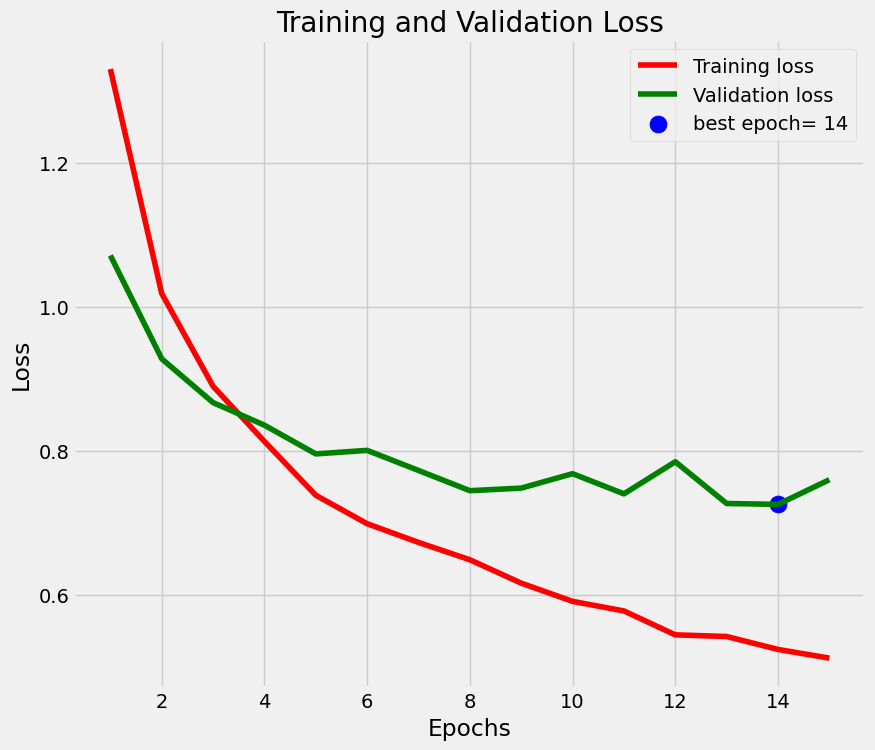

In [ ]:
plot_train_val_loss(history)

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       145
           1       0.86      0.84      0.85       247
           2       0.83      0.78      0.80       155

    accuracy                           0.83       547
   macro avg       0.82      0.82      0.82       547
weighted avg       0.83      0.83      0.83       547



In [ ]:
with open("/content/drive/MyDrive/Năm 3/Big Data/Big Data - Đồ án/model/mlp_model.pkl", "wb") as f:
    pickle.dump(model, f)

## **6.4. Pseudo Labeling**

In [ ]:
df_unlabeled = df.filter(df.label.isNull())
print(df_unlabeled.show(truncate=100))
print("Number of unlabeled comments:", df_unlabeled.count())

+-------------------+----------------------------------------------------------------------------------------------------+-----+
|                cid|                                                                                        text_comment|label|
+-------------------+----------------------------------------------------------------------------------------------------+-----+
|7490136475579171600|                                          da hỗn hợp thiên dầu thì dùng loại nào oke mà giá hs hv ạ?| NULL|
|7492435675065713426|                                                                                      Skin 1004 đi ạ| NULL|
|7498591390076076808|                                                                                   sunplay đỏ đi chị| NULL|
|7490193734711231239|                                garnie đi ạ e cg định mua nhưng mà chưa bt nó có hợp ko rv đi chị 🥰| NULL|
|7496741736116798226|                                                                             

In [ ]:
unlabeled_pd = df_unlabeled.toPandas()

In [ ]:
unlabeled_pd['cleaned_text'] = unlabeled_pd['text_comment'].apply(lambda x: process_text(x, return_str=True))
unlabeled_pd["features"] = unlabeled_pd["text_comment"].progress_apply(extract_features)

In [ ]:
# unlabeled_pd.to_csv('/content/drive/MyDrive/Năm 3/Big Data/Big Data - Đồ án/data/processed/unlabeled_features.tsv', sep='\t', encoding='utf-8', index=False)

In [ ]:
unlabeled_pd = pd.read_csv('/content/drive/MyDrive/Năm 3/Big Data/Big Data - Đồ án/data/processed/unlabeled_features.tsv', sep='\t')
unlabeled_pd.tail()

,cid,text_comment,label,cleaned_text,features
8156,7203744653874955035,"Hiện tại hàng về rất ít, hãng đang phải nhập t...",NaN,hàng hãng nhập hàng đức,[ 1.18560754e-01 2.68800020e-01 6.69425353e-...
8157,7203831948547670811,e dc 4 5 tiếng là mũi lại tràn dầu r a ơi 🥺,NaN,4 5 tiếng mũi tràn dầu,[-3.69028398e-03 -2.29879022e-02 -9.84798521e-...
8158,7203958590297883419,Anh review kcn lar bản mới đi anh,NaN,review kcn lar đi,[ 1.63510740e-01 7.61169642e-02 9.59200785e-...
8159,7217841222398870299,mình xài rất oki hợp luôn sau bao nhiêu lần th...,NaN,xài oki hợp thử,[ 4.62445430e-02 1.89708740e-01 -1.80552408e-...
8160,7211537000117093146,Em bôi kcn laroche này r để 10p xong đánh nền ...,NaN,bôi kcn laroche 10p xong đánh ok,[ 5.83917275e-02 4.78416458e-02 -1.26457229e-...


In [ ]:
unlabeled_pd['features'] = unlabeled_pd['features'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))
X_unlabeled = np.vstack(unlabeled_pd["features"].values)

In [ ]:
with open("/content/drive/MyDrive/Năm 3/Big Data/Big Data - Đồ án/model/mlp_model.pkl", "rb") as f:
    model = pickle.load(f)

In [ ]:
# Dự đoán xác suất với dữ liệu chưa gán nhãn
probs = model.predict(X_unlabeled)

# Lấy độ tin cậy và nhãn tương ứng
confidences = np.max(probs, axis=1)
pseudo_labels = np.argmax(probs, axis=1)

# Chọn mẫu có độ tin cậy cao
high_confidence_mask = confidences > 0.95
X_pseudo = X_unlabeled[high_confidence_mask]
y_pseudo = pseudo_labels[high_confidence_mask]

print(f"Số lượng mẫu pseudo-label: {len(X_pseudo)}")

256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Số lượng mẫu pseudo-label: 3476


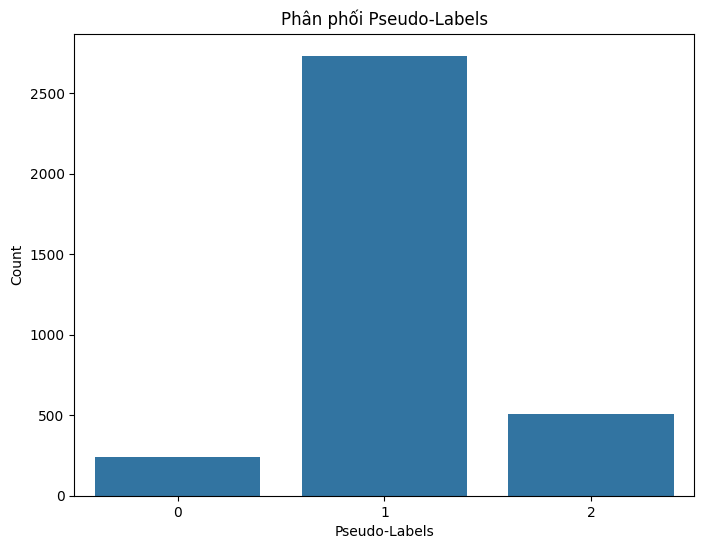

In [ ]:
unique_labels, counts = np.unique(y_pseudo, return_counts=True)

plt.figure(figsize=(8, 6))
sns.barplot(x=unique_labels, y=counts)
plt.xlabel("Pseudo-Labels")
plt.ylabel("Count")
plt.title("Phân phối Pseudo-Labels")
plt.show()

In [ ]:
from collections import Counter
from sklearn.utils import resample

# Kiểm tra phân phối nhãn trong pseudo-label
pseudo_dist = Counter(y_pseudo)
min_count = min(pseudo_dist.values())  # số mẫu ít nhất trong các lớp

# Gộp X và y của pseudo để dễ xử lý
pseudo_data = list(zip(X_pseudo, y_pseudo))

# Nhóm theo nhãn
grouped = {}
for x, y in pseudo_data:
    grouped.setdefault(y, []).append(x)

# Undersample từng nhóm nhãn về số lượng = min_count
X_pseudo_balanced = []
y_pseudo_balanced = []
for label, features in grouped.items():
    sampled = resample(features, n_samples=min_count, random_state=42)
    X_pseudo_balanced.extend(sampled)
    y_pseudo_balanced.extend([label] * min_count)

# Chuyển sang dạng numpy array
X_pseudo_balanced = np.array(X_pseudo_balanced)
y_pseudo_balanced = np.array(y_pseudo_balanced)

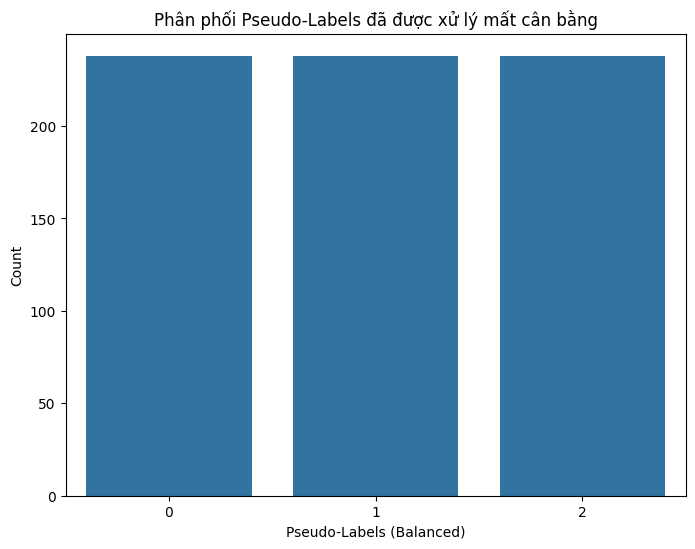

In [ ]:
# Kiểm tra phân phối nhãn trong pseudo-label
unique_labels, counts = np.unique(y_pseudo_balanced, return_counts=True)

plt.figure(figsize=(8, 6))
sns.barplot(x=unique_labels, y=counts)
plt.xlabel("Pseudo-Labels (Balanced)")
plt.ylabel("Count")
plt.title("Phân phối Pseudo-Labels đã được xử lý mất cân bằng")
plt.show()

In [ ]:
# Gộp với tập train thật
X_train_new = np.vstack([X_train, X_pseudo_balanced])
y_train_new = np.concatenate([y_train, y_pseudo_balanced])

In [ ]:
# Trọng số cho mỗi mẫu
weights_real = np.ones(len(y_train))                # Trọng số = 1 cho nhãn thật
weights_pseudo = np.full(len(y_pseudo_balanced), 0.8)        # Trọng số thấp hơn cho nhãn giả

sample_weights = np.concatenate([weights_real, weights_pseudo])

# Huấn luyện lại model với sample_weight
logistic_model.fit(X_train_new, y_train_new, sample_weight=sample_weights)

LogisticRegression(C=0.23357214690901212, max_iter=1000, solver='saga')

In [ ]:
svm_model.fit(X_train_new, y_train_new, sample_weight=sample_weights)
rf_model.fit(X_train_new, y_train_new, sample_weight=sample_weights)

RandomForestClassifier(max_depth=100, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=350)

In [ ]:
print(classification_report(y_test, logistic_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       145
           1       0.86      0.86      0.86       247
           2       0.84      0.82      0.83       155

    accuracy                           0.84       547
   macro avg       0.84      0.84      0.84       547
weighted avg       0.84      0.84      0.84       547



In [ ]:
print(classification_report(y_test, svm_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81       145
           1       0.84      0.85      0.85       247
           2       0.83      0.78      0.80       155

    accuracy                           0.82       547
   macro avg       0.82      0.82      0.82       547
weighted avg       0.82      0.82      0.82       547



In [ ]:
print(classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       145
           1       0.79      0.86      0.82       247
           2       0.78      0.69      0.73       155

    accuracy                           0.78       547
   macro avg       0.77      0.76      0.76       547
weighted avg       0.77      0.78      0.77       547



In [ ]:
# One-hot encode label
y_train_cat_new = to_categorical(y_train_new, num_classes=num_classes)


model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_new.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Dữ liệu validation tách từ tập pseudo ban đầu hoặc từ validation thực
history2 = model.fit(X_train_new, y_train_cat_new,
          validation_data=(X_val, y_val_cat),
          epochs=15,
          batch_size=32,
          callbacks=[early_stopping])


Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6132 - loss: 1.3406 - val_accuracy: 0.7529 - val_loss: 0.9876
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8085 - loss: 0.8348 - val_accuracy: 0.7529 - val_loss: 0.8923
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8327 - loss: 0.7349 - val_accuracy: 0.7671 - val_loss: 0.8219
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8533 - loss: 0.6536 - val_accuracy: 0.7741 - val_loss: 0.7866
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8506 - loss: 0.6078 - val_accuracy: 0.7741 - val_loss: 0.7846
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8589 - loss: 0.5552 - val_accuracy: 0.7647 - val_loss: 0.7399
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8739 - loss: 0.5332 - val_accuracy: 0.7788 - val_loss: 0.7777
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8670 - loss: 0.5145 - val_accuracy: 0.7718 - val_loss

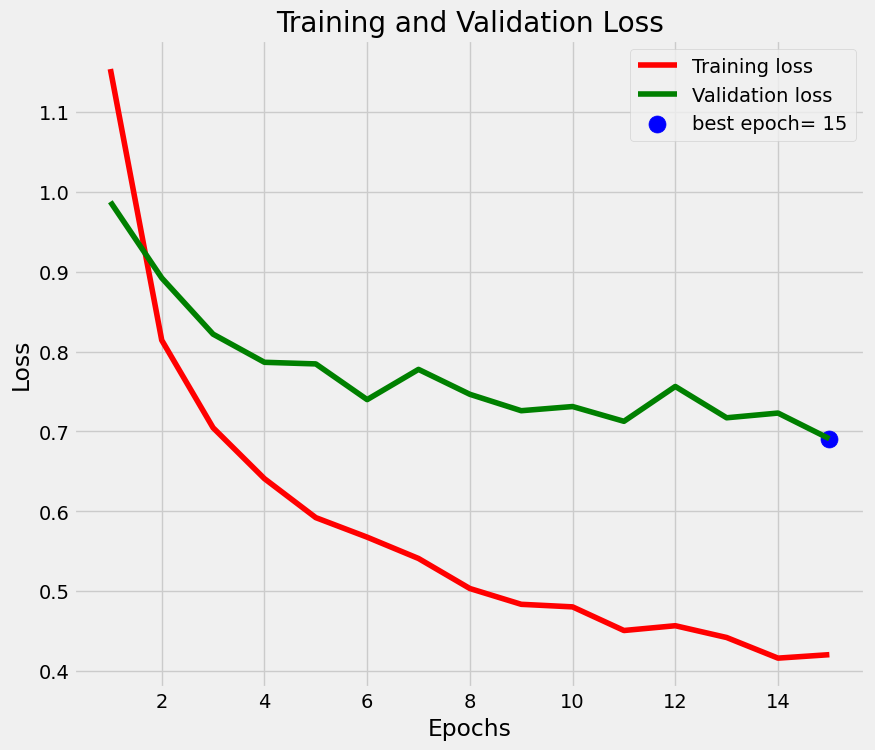

In [ ]:
plot_train_val_loss(history2)


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       145
           1       0.83      0.85      0.84       247
           2       0.80      0.81      0.81       155

    accuracy                           0.82       547
   macro avg       0.81      0.81      0.81       547
weighted avg       0.82      0.82      0.82       547



## **6.5. Confusion Matrix**

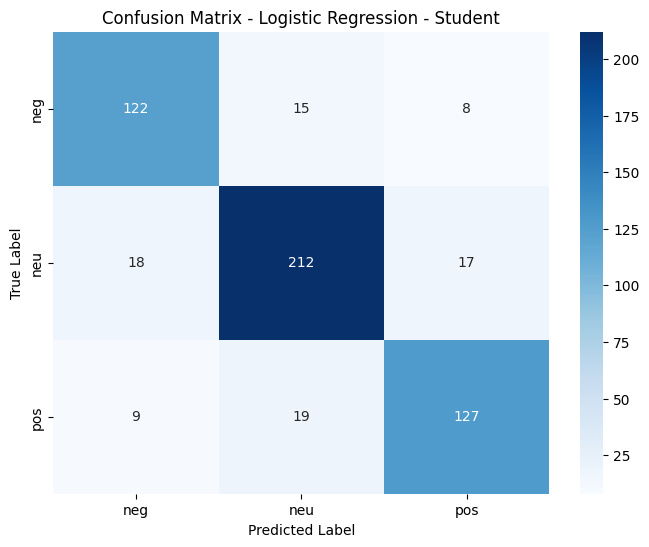

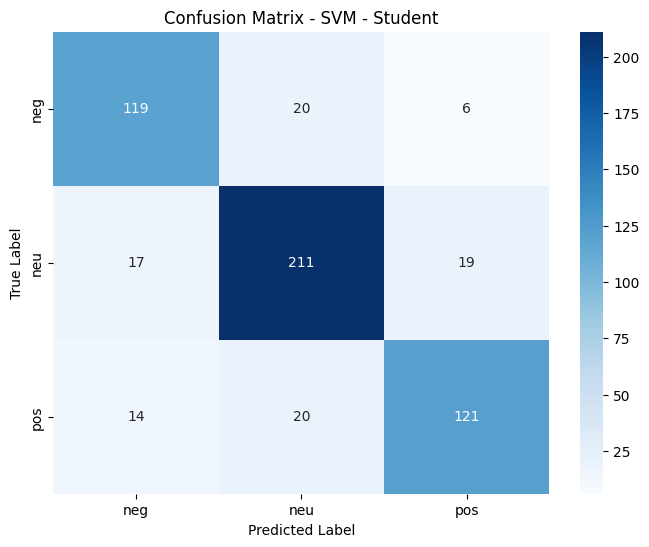

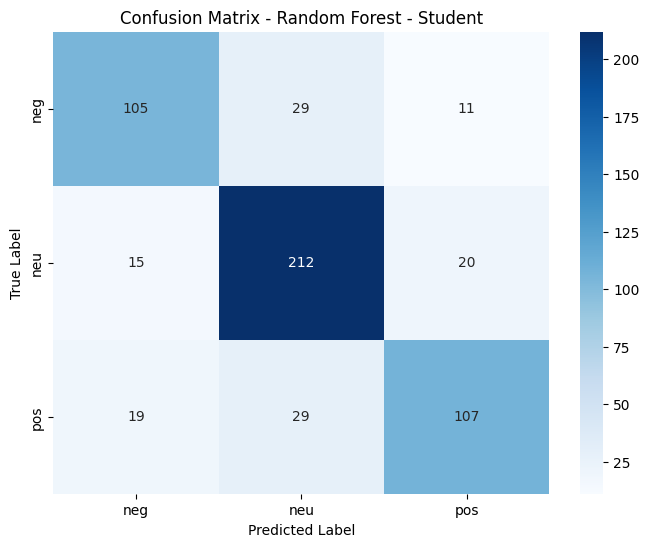

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["neg", "neu", "pos"],
                yticklabels=["neg", "neu", "pos"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

y_pred_logistic = logistic_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

plot_confusion_matrix(y_test, y_pred_logistic, "Logistic Regression - Student")
plot_confusion_matrix(y_test, y_pred_svm, "SVM - Student")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest - Student")


In [ ]:
with open("/content/drive/MyDrive/Năm 3/Big Data/Big Data - Đồ án/model/LogisticRegression_best_model.pkl", "rb") as f:
    parent_logistic_model = pickle.load(f)

with open("/content/drive/MyDrive/Năm 3/Big Data/Big Data - Đồ án/model/SVC_best_model.pkl", "rb") as f:
    parent_svm_model = pickle.load(f)

with open("/content/drive/MyDrive/Năm 3/Big Data/Big Data - Đồ án/model/RandomForestClassifier_best_model.pkl", "rb") as f:
    parent_rf_model = pickle.load(f)

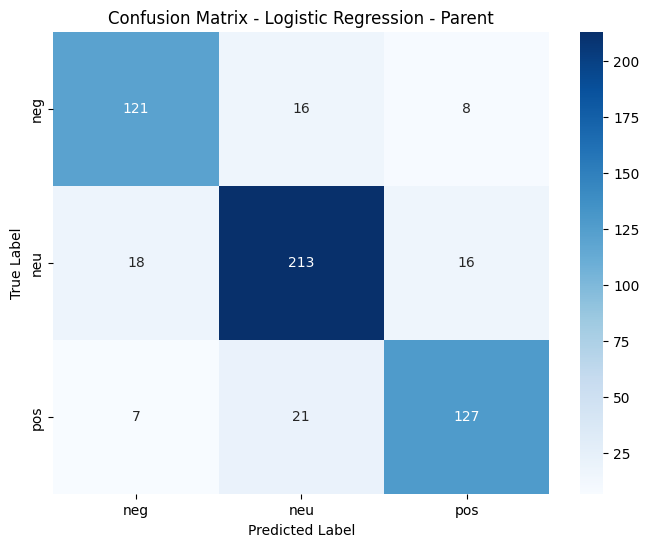

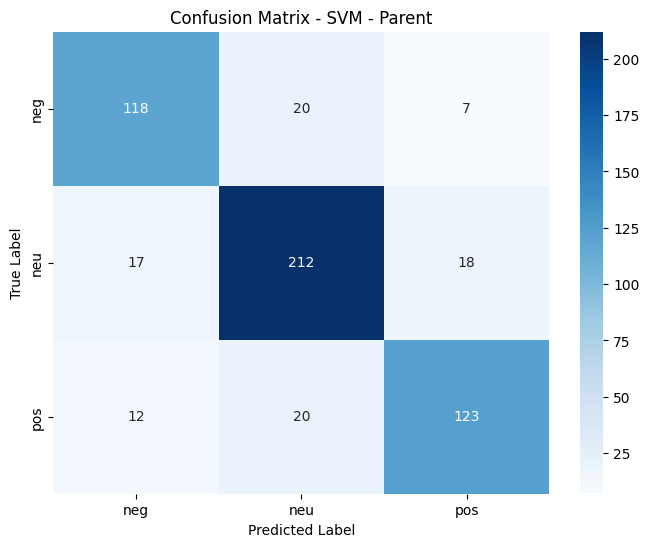

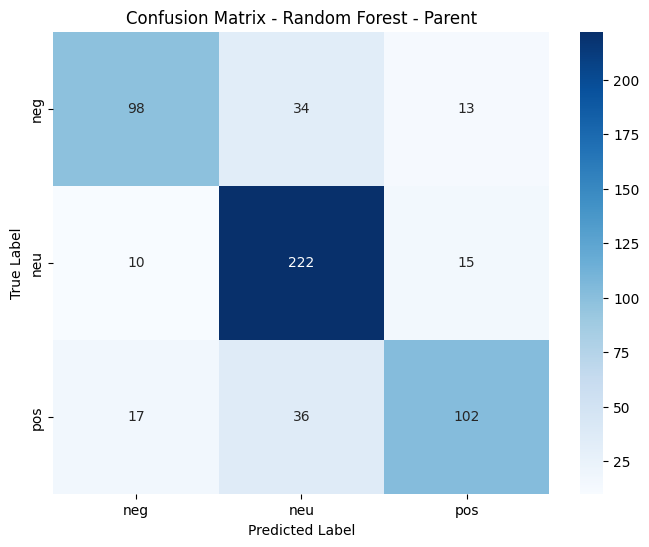

In [ ]:
y_pred_logistic = parent_logistic_model.predict(X_test)
y_pred_svm = parent_svm_model.predict(X_test)
y_pred_rf = parent_rf_model.predict(X_test)

plot_confusion_matrix(y_test, y_pred_logistic, "Logistic Regression - Parent")
plot_confusion_matrix(y_test, y_pred_svm, "SVM - Parent")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest - Parent")

## **6.6. Dự đoán trên dữ liệu nhập vào**

In [ ]:
with open("/content/drive/MyDrive/Năm 3/Big Data/Nhom01/model/LogisticRegression_best_model.pkl", "rb") as f:
    parent_logistic_model = pickle.load(f)

with open("/content/drive/MyDrive/Năm 3/Big Data/Nhom01/model/SVC_best_model.pkl", "rb") as f:
    parent_svm_model = pickle.load(f)

with open("/content/drive/MyDrive/Năm 3/Big Data/Nhom01/model/RandomForestClassifier_best_model.pkl", "rb") as f:
    parent_rf_model = pickle.load(f)

with open("/content/drive/MyDrive/Năm 3/Big Data/Nhom01/model/mlp_model.pkl", "rb") as f:
    parent_mlp_model = pickle.load(f)

In [ ]:
map_labels = {0: "negative", 1: "neutral", 2: "positive"}

In [ ]:
cleaned_text_udf = udf(lambda text: process_text(text, return_str=True), StringType())

In [ ]:
phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

def extract_features(text):
    input_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)])
    with torch.no_grad():
        outputs = phobert(input_ids)
        last_hidden_state = outputs[0]
        sentence_embedding = last_hidden_state.mean(dim=1).squeeze().numpy()
    return sentence_embedding

extract_udf = udf(lambda text: extract_features(text), ArrayType(FloatType()))

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [ ]:
def predict_label(text, model_name):
    vec = extract_features(text)
    if model_name == "logistic":
        model = parent_logistic_model
    elif model_name == "svm":
        model = parent_svm_model
    elif model_name == "rf":
        model = parent_rf_model
    elif model_name == "mlp":
        model = parent_mlp_model
    pred = model.predict([vec])[0]
    return int(pred)

predict_udf = udf(lambda x: predict_label(x[0], x[1]), StringType())

In [ ]:
def predict_from_input(model_name):
    user_input = input("Nhập bình luận TikTok: ")
    cleaned_text = process_text(user_input)
    features = extract_features(cleaned_text)
    if model_name == "logistic":
        model = parent_logistic_model
    elif model_name == "svm":
        model = parent_svm_model
    elif model_name == "rf":
        model = parent_rf_model
    elif model_name == "mlp":
        model = parent_mlp_model
    label = model.predict([features])[0]
    print(f"Mô hình sử dụng: {model_name}")
    print(f"Nhãn dự đoán: {map_labels[label]}")

In [ ]:
predict_from_input("rf")

Nhập bình luận TikTok: review thêm hãng này đi chị, thấy ít người review quá
Mô hình sử dụng: rf
Nhãn dự đoán: neutral
